In [1]:
import os
import numpy as np
from utils import load_mnist_vgg_dataset_model, plot_mnist

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
x_train, y_train, x_test, y_test, model = load_mnist_vgg_dataset_model()
all_layer_names = [layer.name for layer in model.model.layers]
model.model.summary()

Model: "MnistVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256

The following preparation will be done during pre-processing: 

In [3]:
x_test = x_test[:1000]
y_test = y_test[:1000]
dataset = x_test
dataset_labels = y_test
del x_train
del y_train

Make sure "python setup_deepeverest_index.py build" is run ahead of time.

In [4]:
layer_name = "activation_12"
layer_id = all_layer_names.index(layer_name)

In [5]:
import ctypes
lib_file = "/Users/donghe/GoogleDrive/Projects/uwdb-deep-everest/index/build/lib.macosx-10.7-x86_64-3.7/deepeverst_index.cpython-37m-darwin.so"
index_lib = ctypes.CDLL(lib_file)

In [6]:
import math
from utils import *

n_images = len(dataset)
n_partitions= 32
batch_size = 64
ratio = 0.05
bits_per_image = math.ceil(math.log(n_partitions, 2))

In [7]:
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=batch_size)

In [8]:
from DeepEverest import *

rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx, par_low_bound, par_upp_bound = construct_index(
        index_lib=index_lib,
        n_images=n_images,
        ratio=ratio,
        n_partitions=n_partitions,
        bits_per_image=bits_per_image,
        layer_result=layer_result)

The indexes can be persisted to disk with np.save() or pickle.dump() for convenient re-use later.

In [9]:
label_predicted = np.argmax(model.predict(dataset), axis=1)
label_test = np.argmax(dataset_labels, axis=1)

At query time:

In [10]:
misclassified_mask = label_predicted[:1000] != dataset_labels[:1000]
np.where(misclassified_mask)

/Users/donghe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([0]),)

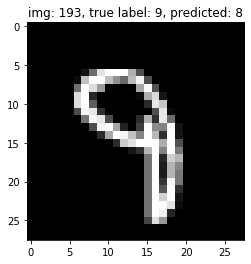

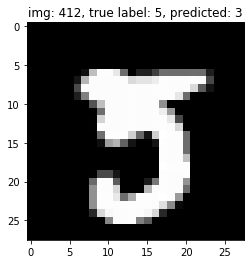

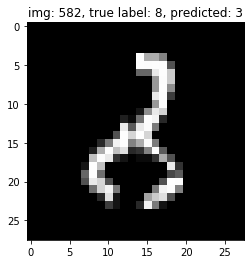

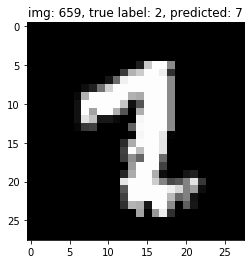

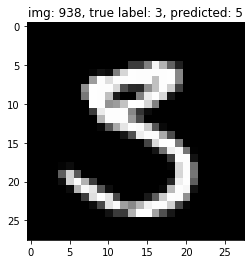

In [11]:
image_ids = [193, 412, 582, 659, 938]
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [12]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = list()
    image_samples = list()
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

In [13]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)[0]
topk_activations_neurons = [x[1] for x in topk_activations]
topk_activations

[(2.2470708, (1, 1, 374)),
 (1.9390898, (0, 0, 113)),
 (1.901135, (0, 0, 358)),
 (1.8457981, (1, 0, 335)),
 (1.8241946, (1, 1, 62)),
 (1.7726848, (1, 0, 182)),
 (1.7536622, (1, 1, 129)),
 (1.7496961, (0, 0, 95)),
 (1.7491626, (1, 0, 441)),
 (1.6753774, (1, 1, 177)),
 (1.6667684, (0, 0, 46)),
 (1.6587315, (0, 1, 340)),
 (1.6440471, (0, 1, 285)),
 (1.6398696, (1, 1, 428)),
 (1.6205437, (0, 1, 365)),
 (1.614127, (0, 1, 461)),
 (1.5758138, (0, 0, 245)),
 (1.5589457, (0, 0, 45)),
 (1.5521429, (0, 1, 336)),
 (1.5128992, (0, 1, 379))]

In [14]:
from NeuronGroup import *
image_sample_id = 659
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=topk_activations_neurons[:3])

In [15]:
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
top_k, exit_msg

image 659, size of neuron group 3
threshold: 0.10419664531946182, max in answer: 1.9318041801452637, images run: 89
threshold: 0.3945380449295044, max in answer: 1.6264116764068604, images run: 164
threshold: 0.5939739942550659, max in answer: 1.4681154489517212, images run: 248
threshold: 1.180732250213623, max in answer: 1.3419102430343628, images run: 325
threshold: 1.3751498460769653, max in answer: 1.3419102430343628, images run: 385
======================= NTA exited =======================


([(-1.3419102, 930),
  (-1.3101325, 111),
  (-1.2900714, 666),
  (-1.2868087, 684),
  (-1.2507521, 689),
  (-1.1397581, 726),
  (-1.1220205, 909),
  (-1.1054937, 730),
  (-1.0767218, 746),
  (-1.0728333, 583),
  (-1.0434676, 551),
  (-1.014565, 321),
  (-0.98903483, 716),
  (-0.9319052, 676),
  (-0.8697327, 649),
  (-0.73697025, 175),
  (-0.6967765, 846),
  (-0.55197114, 468),
  (-0.5042958, 667),
  (0.0, 659)],
 'termination: images run: 385')

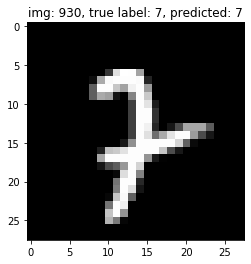

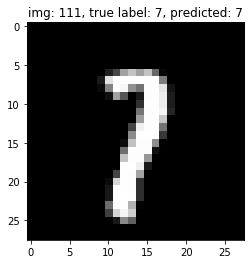

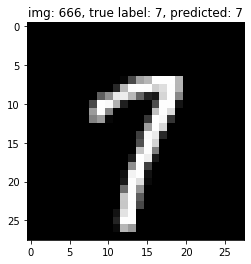

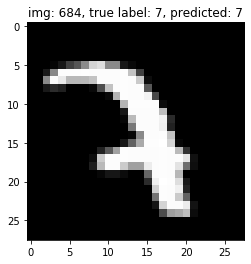

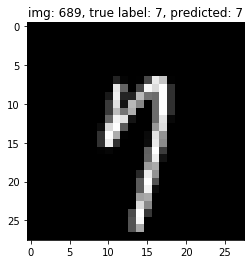

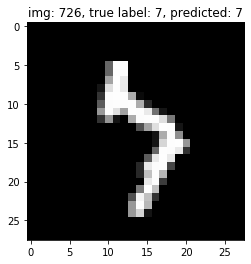

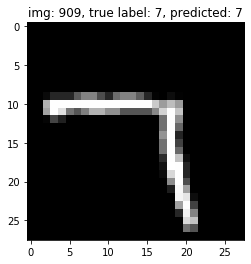

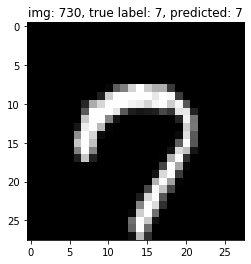

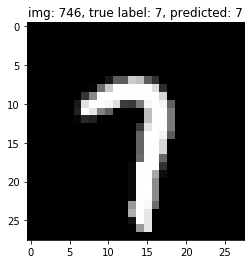

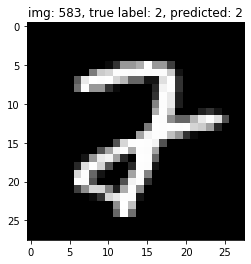

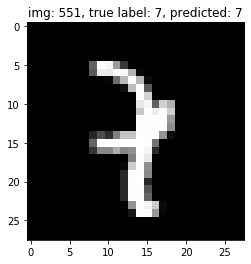

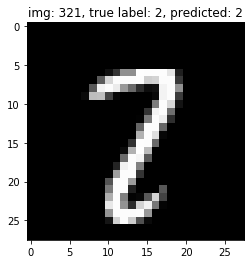

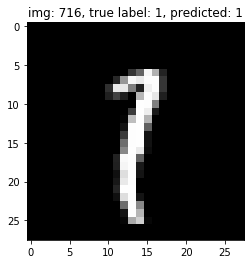

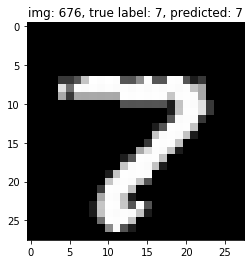

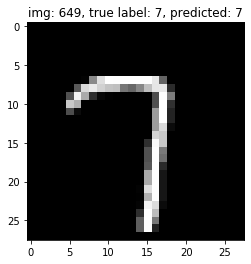

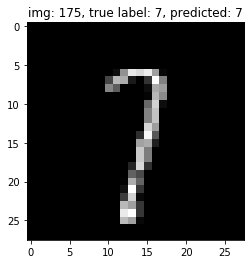

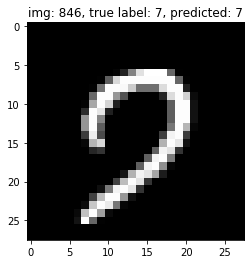

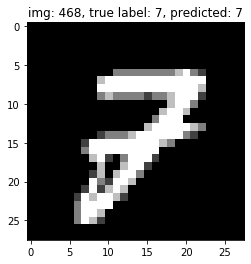

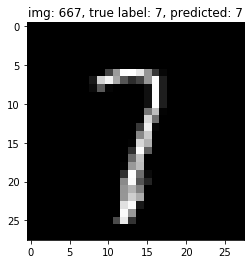

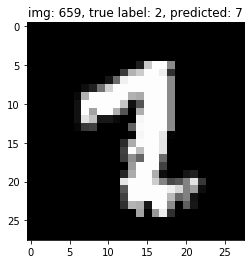

In [16]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [17]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 7

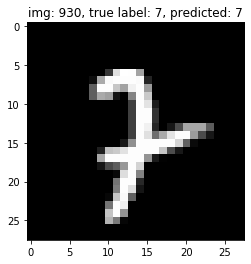

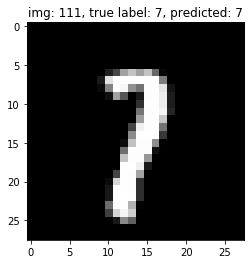

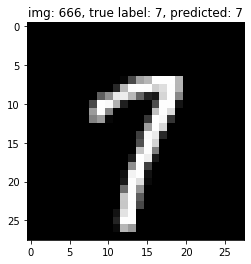

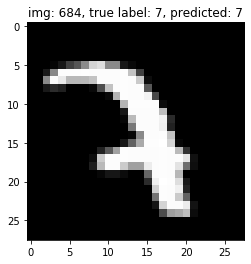

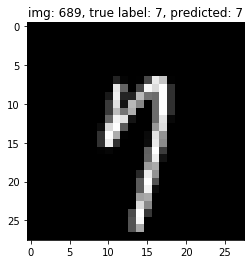

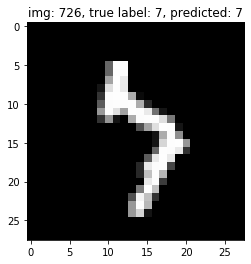

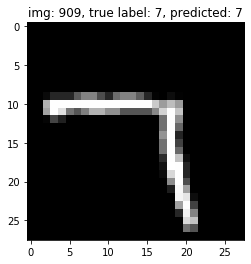

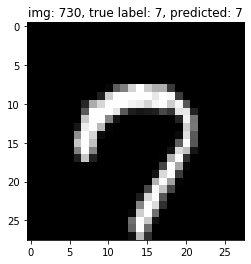

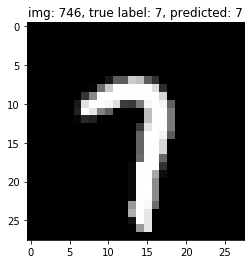

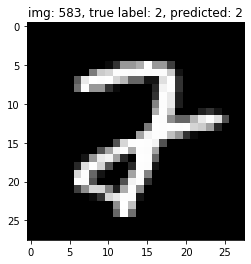

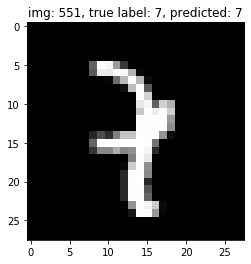

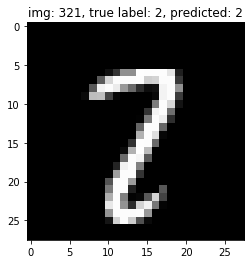

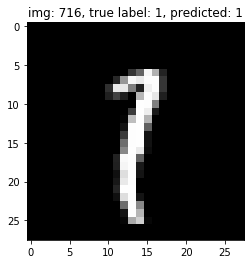

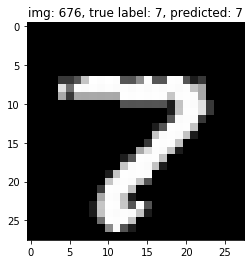

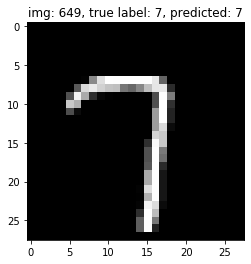

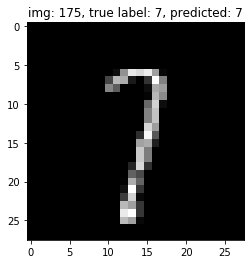

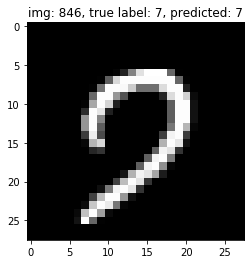

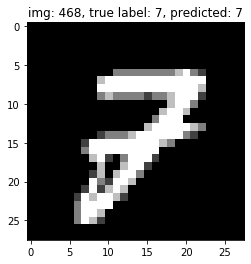

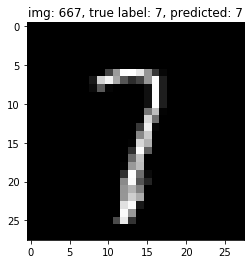

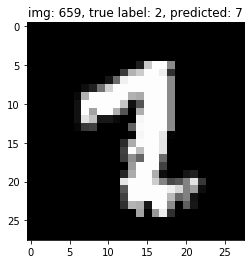

In [18]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(dataset, label_test, image_id, prediction)

In [19]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(x_test.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

In [20]:
image_ids = [two_as_two, seven_as_seven, two_as_seven, seven_as_two]

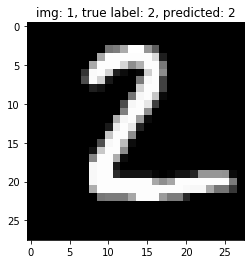

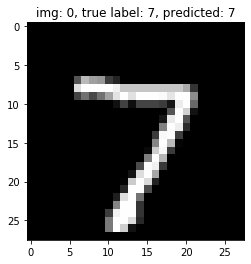

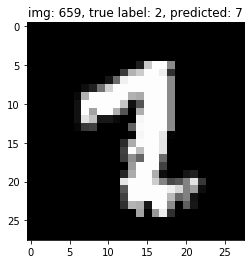

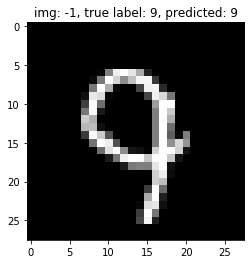

In [21]:
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [22]:
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)
topk_activations

[[(4.870734, (1, 0, 224)),
  (4.747963, (1, 1, 205)),
  (4.7386675, (0, 1, 187)),
  (4.676137, (1, 0, 335)),
  (4.4330807, (0, 1, 39)),
  (4.274835, (1, 0, 322)),
  (4.244879, (1, 0, 424)),
  (4.10975, (0, 1, 14)),
  (4.077998, (0, 0, 194)),
  (4.013324, (1, 0, 441)),
  (3.971671, (1, 1, 271)),
  (3.8842697, (1, 1, 351)),
  (3.866744, (0, 1, 61)),
  (3.8560157, (1, 1, 374)),
  (3.802818, (0, 1, 18)),
  (3.7997165, (0, 0, 45)),
  (3.7284117, (1, 0, 234)),
  (3.5818672, (1, 0, 70)),
  (3.4102287, (0, 1, 285)),
  (3.3216047, (0, 1, 287))],
 [(4.722495, (1, 0, 450)),
  (4.4728017, (0, 0, 358)),
  (4.309978, (0, 1, 236)),
  (4.1930327, (0, 1, 108)),
  (4.1637588, (0, 1, 461)),
  (4.1101875, (0, 0, 436)),
  (4.0633893, (1, 1, 325)),
  (4.0506167, (0, 0, 4)),
  (4.0463285, (1, 1, 374)),
  (4.0063663, (0, 1, 507)),
  (3.9760294, (1, 1, 311)),
  (3.973668, (1, 1, 177)),
  (3.9360485, (1, 1, 96)),
  (3.9359236, (0, 1, 342)),
  (3.9276059, (1, 0, 16)),
  (3.893428, (1, 1, 62)),
  (3.882738, (0, 1

In [23]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1

sorted_neurons = [(k, v) for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)]
sorted_neurons_idx = [x[0] for x in sorted_neurons]
sorted_neurons

[((1, 1, 374), 3),
 ((1, 0, 335), 2),
 ((1, 0, 441), 2),
 ((0, 0, 45), 2),
 ((0, 1, 285), 2),
 ((1, 0, 450), 2),
 ((0, 0, 358), 2),
 ((0, 1, 236), 2),
 ((0, 1, 108), 2),
 ((0, 1, 461), 2),
 ((1, 1, 177), 2),
 ((1, 1, 62), 2),
 ((0, 0, 46), 2),
 ((1, 0, 182), 2),
 ((1, 0, 224), 1),
 ((1, 1, 205), 1),
 ((0, 1, 187), 1),
 ((0, 1, 39), 1),
 ((1, 0, 322), 1),
 ((1, 0, 424), 1),
 ((0, 1, 14), 1),
 ((0, 0, 194), 1),
 ((1, 1, 271), 1),
 ((1, 1, 351), 1),
 ((0, 1, 61), 1),
 ((0, 1, 18), 1),
 ((1, 0, 234), 1),
 ((1, 0, 70), 1),
 ((0, 1, 287), 1),
 ((0, 0, 436), 1),
 ((1, 1, 325), 1),
 ((0, 0, 4), 1),
 ((0, 1, 507), 1),
 ((1, 1, 311), 1),
 ((1, 1, 96), 1),
 ((0, 1, 342), 1),
 ((1, 0, 16), 1),
 ((0, 1, 170), 1),
 ((0, 0, 104), 1),
 ((0, 0, 113), 1),
 ((1, 1, 129), 1),
 ((0, 0, 95), 1),
 ((0, 1, 340), 1),
 ((1, 1, 428), 1),
 ((0, 1, 365), 1),
 ((0, 0, 245), 1),
 ((0, 1, 336), 1),
 ((0, 1, 379), 1),
 ((0, 0, 330), 1),
 ((1, 1, 413), 1),
 ((1, 1, 297), 1),
 ((1, 1, 452), 1),
 ((1, 0, 306), 1),
 ((0, 

image 659, size of neuron group 1
threshold: 0.09859442710876465, max in answer: 0.04952430725097656, images run: 31
======================= NTA exited =======================


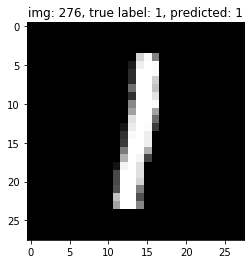

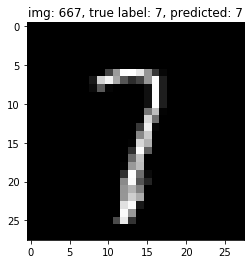

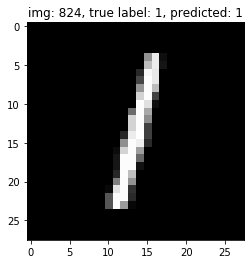

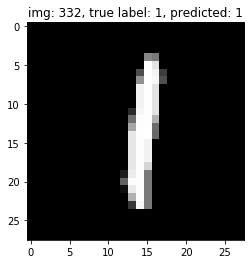

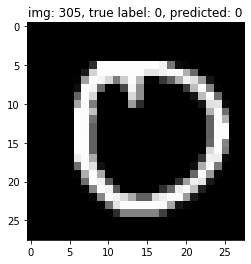

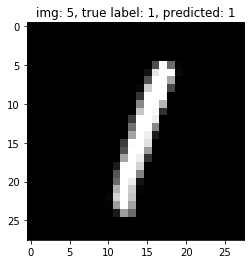

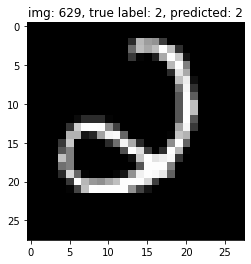

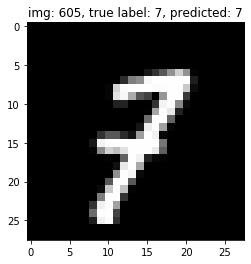

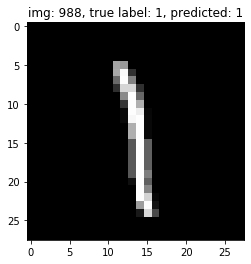

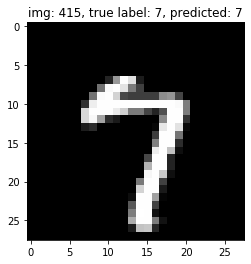

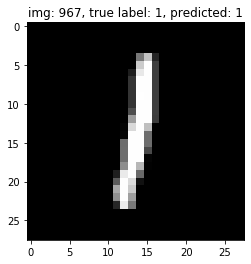

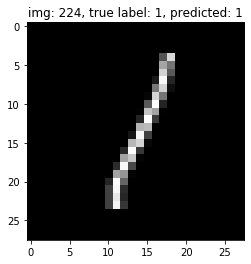

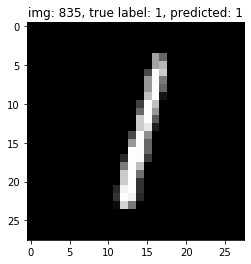

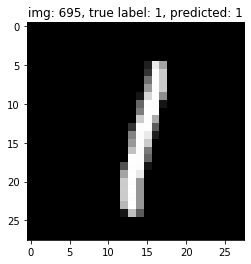

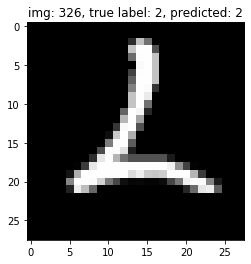

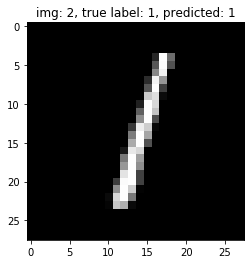

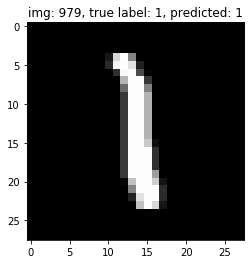

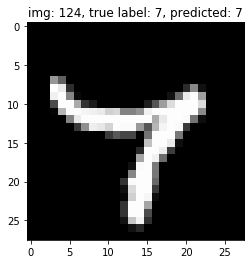

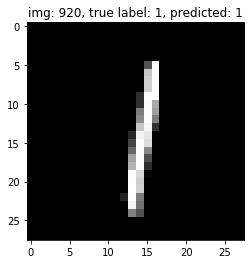

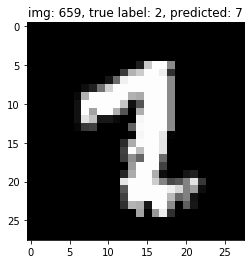

In [24]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=sorted_neurons_idx[:1])
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [25]:
def get_topk_images_given_neuron(rev_idx, idx_of_rev_idx, layer_id, neuron_idx, k):
    key = (layer_id,) + neuron_idx
    reverse_index = rev_idx[idx_of_rev_idx[key]]
    res = list()
    i = len(reverse_index.activations_with_idx) - 1
    while i >= 0:
        res.append(reverse_index.activations_with_idx[i][1])
        i -= 1
        if len(res) >= k:
            break
    return res

image 659, size of neuron group 1
threshold: 0.019940614700317383, max in answer: 0.043772101402282715, images run: 31
threshold: 0.11408638954162598, max in answer: 0.036948561668395996, images run: 62
======================= NTA exited =======================


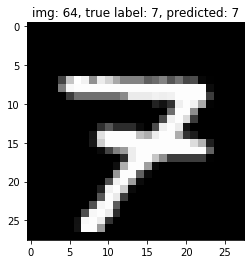

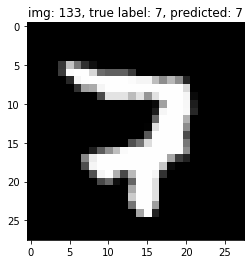

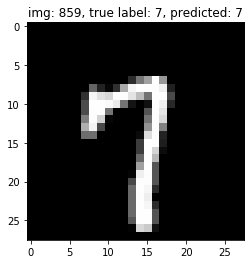

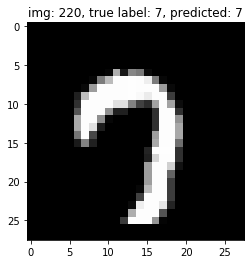

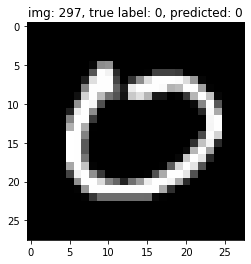

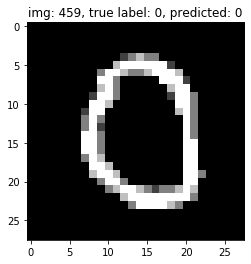

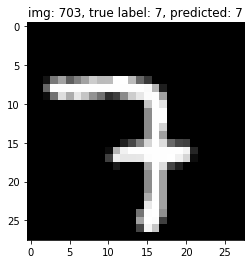

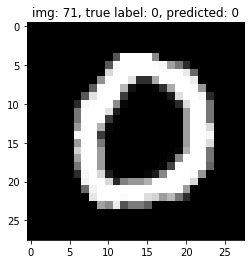

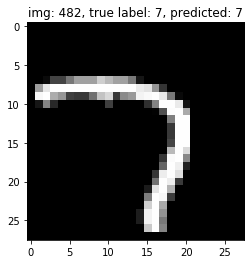

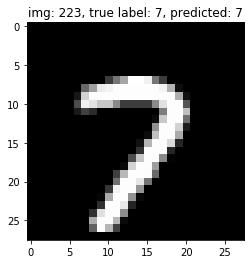

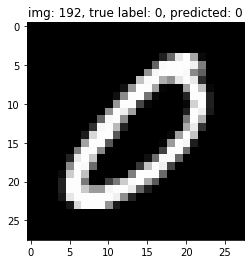

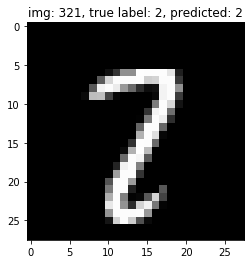

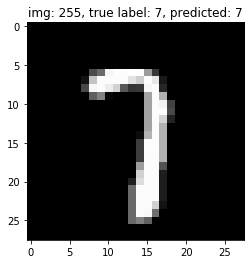

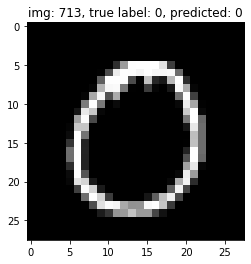

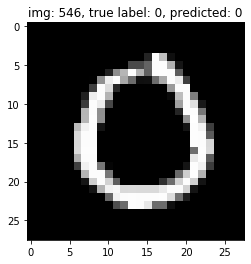

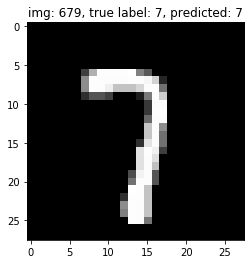

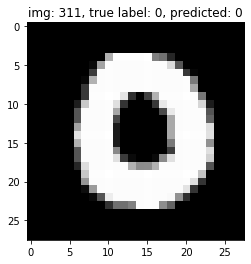

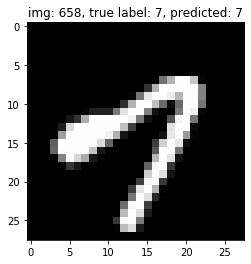

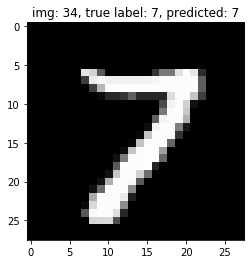

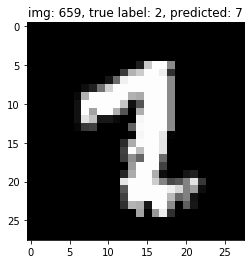

In [26]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=[(1, 0, 441)])
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)

for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [27]:
confusion_activations = [topk_activations[2], topk_activations[3]]
neuron_cnt = dict()
for topk_activation in confusion_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(1, 1, 374): 1,
 (0, 0, 113): 1,
 (0, 0, 358): 1,
 (1, 0, 335): 1,
 (1, 1, 62): 1,
 (1, 0, 182): 1,
 (1, 1, 129): 1,
 (0, 0, 95): 1,
 (1, 0, 441): 1,
 (1, 1, 177): 1,
 (0, 0, 46): 1,
 (0, 1, 340): 1,
 (0, 1, 285): 1,
 (1, 1, 428): 1,
 (0, 1, 365): 1,
 (0, 1, 461): 1,
 (0, 0, 245): 1,
 (0, 0, 45): 1,
 (0, 1, 336): 1,
 (0, 1, 379): 1,
 (0, 0, 330): 1,
 (1, 1, 413): 1,
 (0, 1, 236): 1,
 (1, 1, 297): 1,
 (0, 1, 108): 1,
 (1, 1, 452): 1,
 (1, 0, 306): 1,
 (0, 0, 278): 1,
 (0, 1, 353): 1,
 (0, 1, 121): 1,
 (1, 1, 489): 1,
 (0, 0, 39): 1,
 (1, 0, 450): 1,
 (0, 1, 256): 1,
 (0, 1, 447): 1,
 (0, 1, 409): 1,
 (1, 1, 223): 1,
 (0, 0, 423): 1,
 (1, 0, 267): 1,
 (0, 0, 343): 1}

image 659, size of neuron group 68
threshold: 0.2298397719860077, max in answer: 2.9282844066619873, images run: 611
threshold: 0.8443644642829895, max in answer: 2.8691179752349854, images run: 830
threshold: 1.104892373085022, max in answer: 2.8691179752349854, images run: 932
threshold: 1.445488452911377, max in answer: 2.8691179752349854, images run: 973
threshold: 1.5732320547103882, max in answer: 2.8691179752349854, images run: 992
threshold: 1.7808449268341064, max in answer: 2.8691179752349854, images run: 998
threshold: 1.9629004001617432, max in answer: 2.8691179752349854, images run: 999
threshold: 2.082104444503784, max in answer: 2.8691179752349854, images run: 1000


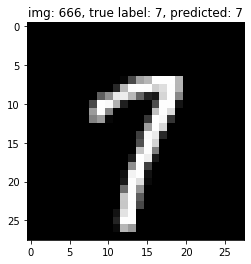

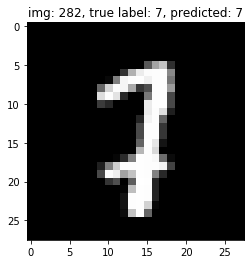

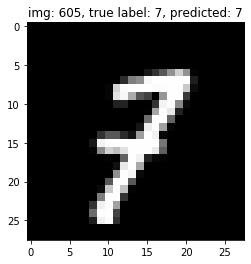

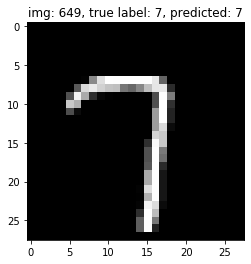

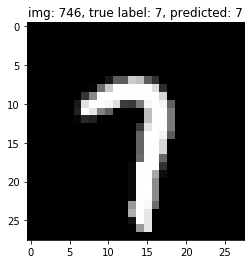

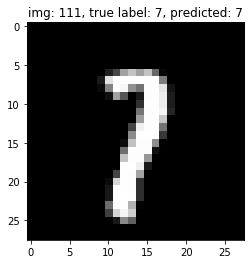

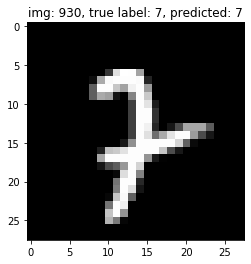

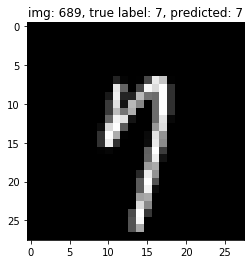

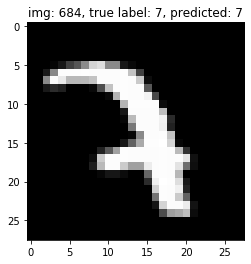

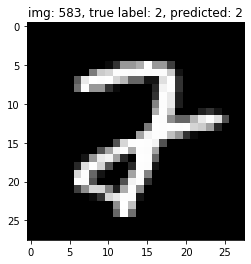

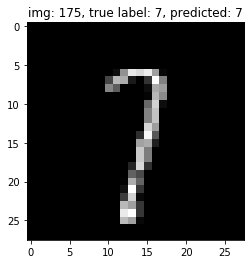

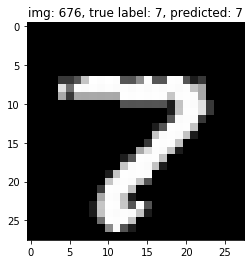

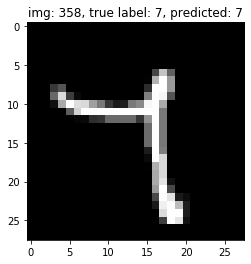

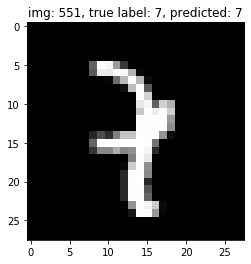

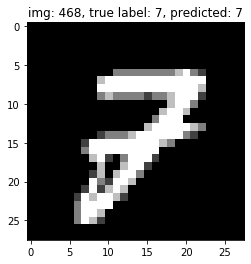

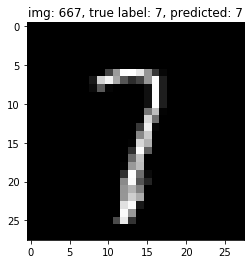

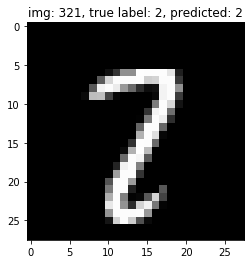

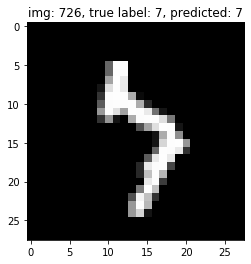

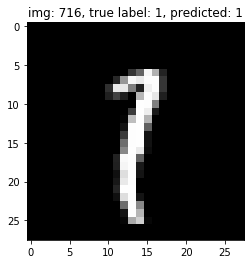

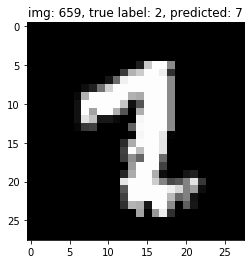

In [28]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, dimension_ranges=[(1, 2), (1, 2), (62, 130)])
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)